## CpGs, Horvath 335 Correlation with Age, and the Common 14 

### Summary

In this notebook we have take in the PPMI Methylation data, process it to a dataframe named df_betas_335, with 335 CpG columns of the 353 CpGs from Horvath 2013 (Horvath 2013, Genome Biology , 14:R115:1-19) the ones that they found correlated with age. Only 335 of these CpGs were in out data.

Then the following is done:
* PCA is performed on these 335 CpGs and the first 10 PCs are saved.
* A PCA plot is presented PC1 and PC2
* A regression plot is presented with Age and PC1
* A linear regression model is run, regressing all 10 PCs and Age
* Which CpGs are common to the Jorvath 335 and the PPMI top1000 is determined (there are 14)
* An anlysis is done then with just those 14 Cpgs

### Results
* Although the individual 335 Horvath CpGs show a correlation with age that is roughly spread in a gaussian around 0, there does seem to be a correaltion between PC2 and age (r = 0.410), and a linear regression model with 10 PCs yields a R^2 value of 0.729, which shows some promise for predicting age with methylation.
* The 335 Horvath CpGs have in common 14 CpGs with the PPMI top 1000. An analysis with these 14 CpGs yielded linear regression models, either directly or with PCs, with R^2 values between the 0.73 and 0.78. The first 7 PCs seemed to be all that mattered in elevating r^2


In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import csv
import random

Files needed:    
* keycpgs.csv (CpGs from Horvath et al 2013)
* beta_post_Funnorm_PPMI_EPICn524final030618.csv  (Giant CpG datafile, 8 GB)
* Patient_Status.csv (Links PATNO with status, that is if healthy Control or not)
* PPMI_Meth_n524_for_LONI030718.txt (Links PATNO to Sentrix ID and Sentrix Position number)
* PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv (Links PATNO and Age)

In [6]:
#Function to select only certain rows of a CSV file as its read in
def select_rows_in(file_to_read, file_to_write, rows):
    '''
    Takes an input csv file and writes a smaller csv file containing
    only the rows in the list rows. 
    
    params: 
        file_to_read (string) (file.csv) path to some existing csv file to read
        file_to_write (string) (file.csv) path to csv file to write as output
        rows (list) list of rows index values to indicate which rows to keep

    '''
    with open(file_to_read, 'r') as file_in:

        csv_in = csv.reader(file_in)

        header = next(csv_in)
        
        count = 0  
        with open(file_to_write, 'w') as file_out:

            csv_out = csv.writer(file_out)
            csv_out.writerow(header)
                         
            for line in csv_in:
                if line[0] in rows:
                    csv_out.writerow(line)
                    count+=1
                    
                        
    print(f'A file named {file_to_write} has been created with {count} rows.')
          

### Reading in data and selcting the 335 Horvath rows

In [79]:
# I have created a file keycpgs.csv that lists all the CpG sites from Horvath et al 2013,
# that they found most importan and are i out data,  335 in all.
# Reading into a dataframe the CpG values to keep from Horvath 2013 
# supplemental file 3,  335 CpGs correlated with aging 
df_353 = pd.read_csv('../files/keycpgs.csv')
keep = list(df_353.CpGMarker) # make list oif CpGs to keep

In [81]:
%%time
# Select out the 353 rows of interest from > 850, 000 rows of giant CpG file (takes ~1 min 39s)
# only 335 were found in the PPMI data
select_rows_in('../files/beta_post_Funnorm_PPMI_EPICn524final030618.csv',  '../files/beta_post_kept.csv', rows=keep)

A file named ../files/beta_post_kept.csv has been created with 335 rows.
CPU times: user 1min 39s, sys: 1.59 s, total: 1min 41s
Wall time: 1min 41s


In [48]:
# Read in data with just 335 Horvath rows
df_beta_keep = pd.read_csv('../files/beta_post_kept.csv')
df_beta_keep

,200973410159_R03C01,200991620021_R01C01,200991620021_R03C01,200989060105_R03C01,200989060135_R07C01,200989060162_R04C01,200973410167_R04C01,200973410143_R01C01,200973410143_R06C01,200973410167_R05C01,200973410167_R08C01,200989060001_R06C01,200989060130_R01C01,201004820204_R02C01,200973410121_R04C01,201004820204_R01C01,201004820204_R07C01,200989060051_R05C01,200973410159_R07C01,200989060143_R08C01,200989060061_R07C01,200973410144_R07C01,200989060002_R01C01,201004820064_R05C01,201004820067_R08C01,201050360014_R02C01,200989060162_R02C01,200989060162_R01C01,200973410159_R02C01,200991620021_R05C01,201050360065_R07C01,201050360065_R08C01,200989060105_R05C01,200989060135_R04C01,200989060135_R01C01,200989060135_R06C01,200989060152_R03C01,200989060152_R06C01,200989060140_R08C01,200989060018_R03C01,200989060088_R03C01,200989060130_R03C01,200989060140_R07C01,200989060104_R03C01,200989060149_R05C01,200989060076_R05C01,200989060076_R06C01,200989060019_R08C01,200989060051_R03C01,200989060063_R08C01,...,200991620029_R02C01,200989060128_R06C01,200991620011_R05C01,200989060063_R01C01,200973410144_R05C01,200989060051_R02C01,201050360013_R02C01,201004820182_R04C01,200989060059_R03C01,201004820182_R02C01,200989060002_R07C01,200989060002_R06C01,200989060059_R02C01,200989060002_R05C01,201050360013_R03C01,200989060002_R08C01,200989060002_R04C01,201004820064_R03C01,201004820064_R02C01,200989060016_R01C01,200989060155_R04C01,200989060016_R03C01,201004820067_R01C01,201050360080_R01C01,200989060015_R06C01,201004820067_R03C01,200989060015_R05C01,200989060155_R02C01,201004820067_R02C01,201004820064_R01C01,200989060016_R02C01,200989060155_R01C01,200989060155_R03C01,200989060111_R02C01,200989060089_R05C01,200989060089_R08C01,200973410143_R03C01,200989060089_R06C01,200973410143_R02C01,200989060089_R07C01,200989060089_R02C01,200989060089_R01C01,200989060089_R04C01,200973410143_R08C01,200973410143_R07C01,200989060089_R03C01,200989060150_R04C01,200989060150_R05C01,200989060150_R06C01,200991620049_R08C01
cg13319175,0.916345,0.876005,0.881291,0.899211,0.867874,0.897708,0.871227,0.865747,0.869889,0.857018,0.892127,0.927430,0.898095,0.901209,0.878139,0.897519,0.919912,0.909166,0.897363,0.899597,0.913324,0.906904,0.898545,0.861094,0.902422,0.921204,0.899402,0.874042,0.936332,0.875255,0.876821,0.931561,0.883577,0.896184,0.878123,0.875765,0.880811,0.889130,0.882632,0.858117,0.862757,0.886989,0.902004,0.880851,0.926401,0.900353,0.914724,0.907060,0.905040,0.884370,...,0.920556,0.875876,0.915823,0.876539,0.914493,0.894515,0.898725,0.890642,0.875103,0.904435,0.893954,0.913948,0.886439,0.876601,0.852615,0.895850,0.895640,0.885598,0.890469,0.891203,0.910783,0.911835,0.849204,0.868406,0.886590,0.862745,0.897424,0.890681,0.883839,0.890066,0.893017,0.886585,0.896447,0.908400,0.896727,0.889071,0.895682,0.919407,0.892414,0.890483,0.903454,0.874479,0.886547,0.903353,0.874404,0.901497,0.901106,0.904594,0.906945,0.900819
cg21211748,0.047419,0.030216,0.076499,0.034195,0.041080,0.039377,0.064212,0.030131,0.027508,0.075733,0.061607,0.042668,0.038038,0.045508,0.039002,0.045152,0.037788,0.029904,0.055917,0.032440,0.049021,0.040951,0.041700,0.040622,0.032647,0.028520,0.044752,0.076612,0.044435,0.042660,0.045388,0.033342,0.048191,0.045820,0.041412,0.034575,0.066650,0.034762,0.069202,0.057960,0.054692,0.030165,0.068611,0.022271,0.040550,0.032001,0.032455,0.044891,0.044013,0.069246,...,0.034591,0.034910,0.030977,0.046048,0.032656,0.041572,0.036654,0.038555,0.034846,0.045215,0.050157,0.038743,0.027520,0.034853,0.102066,0.028284,0.032630,0.040133,0.056641,0.056894,0.043156,0.052440,0.035643,0.051339,0.040201,0.035783,0.038368,0.042958,0.037987,0.040536,0.044133,0.033566,0.046383,0.048084,0.030749,0.028954,0.027162,0.024336,0.024664,0.029273,0.042628,0.026849,0.032234,0.027519,0.032025,0.034256,0.031233,0.034991,0.039544,0.045187
cg19420968,0.935816,0.882283,0.937541,0.899474,0.889517,0.941420,0.925693,0.906165,0.918314,0.931796,0.934539,0.931074,0.930660,0.930587,0.921493,0.916475,0.907264,0

### Processing to a useful dataframe with age and PATNO number

In [49]:
# read in file with patient numbers PATNO and statuses
df_patient = pd.read_csv('../files/Patient_Status.csv')

In [50]:
# Make new patient status dataframe with just Healthy Control patients
df_HC = df_patient[df_patient['RECRUITMENT_CAT'] == 'HC']

In [51]:
# Read in file linking PATNOs to Sentrix numbers, these are numbers in the big CpG file 
# There arte no PATNO numbers there, so they need to be matched up
df_PATNO_Sentrix = pd.read_csv('../files/PPMI_Meth_n524_for_LONI030718.txt', sep = "\t")

In [52]:
# Fix an error in the file
df_PATNO_Sentrix.iloc[374, 0] = '3794'

In [53]:
# Make two dictionaries, linking PATNO to Sentrix number and vice versa
dict_PATNO_to_Sentrix = {}
dict_Sentrix_to_PATNO = {} 
for index, row in df_PATNO_Sentrix.iterrows():
    dict_PATNO_to_Sentrix[row[0]] = str(row[1])+"_"+str(row[2])
    dict_Sentrix_to_PATNO[str(row[1])+"_"+str(row[2])] = row[0]

In [54]:
# Figure out which columns in df_beta_keep are from healthy controls 
cols_to_drop = []
cols_to_keep = [] 
for col in df_beta_keep.columns:
    if int(dict_Sentrix_to_PATNO[col]) in list(df_HC.PATNO):
        cols_to_keep.append(col)

In [55]:
# New df,  df_beta_keep but with now only healthy controls, PD patients dropped
df_beta_keep_HC = df_beta_keep[cols_to_keep]

In [56]:
df_beta_keep_HC

,200973410159_R03C01,200989060135_R07C01,200973410143_R01C01,200973410143_R06C01,200973410167_R08C01,200989060130_R01C01,201004820204_R02C01,201004820067_R08C01,200991620021_R05C01,200989060135_R06C01,200989060152_R06C01,200989060140_R08C01,200989060018_R03C01,200989060088_R03C01,200989060130_R03C01,200989060140_R07C01,200991620035_R06C01,200989060009_R06C01,200991620021_R06C01,200991620021_R08C01,201046420088_R05C01,200989060140_R02C01,200989060140_R06C01,200989060105_R04C01,201050360065_R04C01,200989060136_R02C01,200989060032_R08C01,200989060149_R04C01,200989060080_R04C01,200989060124_R04C01,201004820067_R07C01,200989060152_R07C01,200989060032_R04C01,201050360072_R01C01,200989060032_R03C01,200991620030_R06C01,200989060130_R08C01,200991620049_R03C01,200973410179_R01C01,200991620029_R06C01,200989060105_R06C01,200991620011_R01C01,200973410144_R02C01,200989060050_R03C01,200989060088_R04C01,200973410161_R08C01,200991620030_R04C01,200989060080_R06C01,200973410179_R05C01,200973410179_R04C01,...,201004820171_R04C01,200973410167_R07C01,200989060143_R01C01,201050360072_R03C01,200991620011_R04C01,200991620025_R04C01,200989060130_R02C01,200989060061_R01C01,200989060121_R06C01,201050360075_R08C01,201050360013_R04C01,201004820064_R04C01,201050360013_R07C01,200989060061_R03C01,200989060051_R07C01,200991620029_R05C01,200989060158_R04C01,200989060175_R01C01,200991620008_R02C01,200989060097_R05C01,200989060175_R04C01,200989060121_R05C01,200989060032_R06C01,200989060018_R02C01,200989060104_R02C01,201004820202_R04C01,200989060015_R04C01,200989060015_R02C01,200989060059_R05C01,200973410161_R05C01,200989060018_R04C01,200973410159_R04C01,201050360014_R06C01,200989060015_R03C01,200991620025_R03C01,200989060059_R01C01,200989060111_R01C01,200989060128_R05C01,201050360013_R02C01,200989060002_R07C01,200989060002_R06C01,201004820067_R01C01,200989060111_R02C01,200989060089_R05C01,200973410143_R03C01,200989060089_R07C01,200973410143_R08C01,200973410143_R07C01,200989060089_R03C01,200991620049_R08C01
cg13319175,0.916345,0.867874,0.865747,0.869889,0.892127,0.898095,0.901209,0.902422,0.875255,0.875765,0.889130,0.882632,0.858117,0.862757,0.886989,0.902004,0.909504,0.905296,0.903099,0.894833,0.898626,0.898248,0.896407,0.916624,0.889320,0.897319,0.873619,0.905743,0.899801,0.840989,0.873608,0.871113,0.895016,0.890472,0.883014,0.894193,0.891021,0.872928,0.910269,0.874630,0.913714,0.910523,0.901027,0.912524,0.877613,0.844620,0.912598,0.890005,0.898322,0.894314,...,0.900649,0.876617,0.915489,0.857675,0.914109,0.890535,0.901654,0.893130,0.891184,0.891269,0.893539,0.887974,0.864464,0.922636,0.874028,0.866359,0.909018,0.912920,0.887082,0.916420,0.890056,0.883664,0.922887,0.894289,0.895955,0.908453,0.911143,0.880223,0.900821,0.842392,0.884729,0.909293,0.927231,0.884049,0.883555,0.836911,0.903943,0.879061,0.898725,0.893954,0.913948,0.849204,0.908400,0.896727,0.895682,0.890483,0.903353,0.874404,0.901497,0.900819
cg21211748,0.047419,0.041080,0.030131,0.027508,0.061607,0.038038,0.045508,0.032647,0.042660,0.034575,0.034762,0.069202,0.057960,0.054692,0.030165,0.068611,0.046307,0.047889,0.045347,0.038912,0.045059,0.056467,0.042646,0.069762,0.043310,0.037805,0.026429,0.026965,0.045290,0.046856,0.031334,0.030637,0.071653,0.049275,0.047978,0.046127,0.030826,0.077734,0.046233,0.038063,0.048777,0.036537,0.048026,0.063174,0.058390,0.068986,0.052382,0.031948,0.047909,0.046850,...,0.027415,0.060776,0.044469,0.039873,0.037405,0.037201,0.039144,0.054658,0.038347,0.025318,0.035340,0.044606,0.038709,0.038257,0.050059,0.030740,0.035380,0.046964,0.030904,0.034620,0.039696,0.044134,0.036750,0.088954,0.036274,0.031362,0.049800,0.033785,0.051614,0.081192,0.049305,0.028278,0.033745,0.052923,0.040183,0.049715,0.039087,0.043298,0.036654,0.050157,0.038743,0.035643,0.048084,0.030749,0.027162,0.029273,0.027519,0.032025,0.034256,0.045187
cg19420968,0.935816,0.889517,0.906165,0.918314,0.934539,0.930660,0.930587,0.904941,0.902234,0.914225,0.919984,0.934099,0.839931,0.910730,0.944695,0.942856,0.920388,0

In [57]:
# Make Final df transposed, columns equal CpGs, rows = PATNO of healthy controls, 
# Values = beta values, only 335 CpGs from Horvath et al 2013 supplemental file 3
patnos = []
for col in df_beta_keep_HC.columns:
    patnos.append(dict_Sentrix_to_PATNO[col])
df_betas = df_beta_keep_HC.copy()
df_betas.columns = patnos
df_betas_t = df_betas.transpose()
df_betas_t.insert(0, "PATNO", df_betas_t.index)
df_betas_t= df_betas_t.reset_index(drop = True)
df_betas_t

,PATNO,cg13319175,cg21211748,cg19420968,cg14992253,cg26372517,cg07388493,cg19044674,cg23786576,cg18983672,cg10266490,cg06836772,cg22901840,cg09118625,cg08413469,cg19514928,cg05675373,cg10045881,cg18031008,cg07337598,cg16168311,cg01459453,cg02275294,cg21870884,cg15262928,cg24450312,cg09885951,cg27202708,cg26043391,cg09809672,cg11314684,cg25657834,cg08030082,cg14424579,cg12351433,cg02154074,cg01968178,cg22809047,cg21378206,cg17099569,cg08251036,cg05847778,cg13038560,cg03947362,cg11388238,cg10376763,cg10523019,cg20795863,cg25781123,cg04005032,...,cg17324128,cg09019938,cg13129046,cg01560871,cg04268405,cg18180783,cg04126866,cg19346193,cg00436603,cg24126851,cg13216057,cg25505610,cg06513075,cg22637507,cg20240860,cg21370143,cg01511567,cg24580001,cg08965235,cg13547237,cg07730301,cg19692710,cg16547529,cg17063929,cg14727952,cg25101936,cg21096399,cg10377274,cg01234063,cg26723847,cg16579101,cg01820374,cg00431549,cg13302154,cg19722847,cg25683012,cg02364642,cg18573383,cg09418283,cg00864867,cg07498421,cg06462291,cg26297688,cg10281002,cg24254120,cg04836038,cg09646392,cg01027805,cg06738602,cg15661409
0,3000,0.916345,0.047419,0.935816,0.113106,0.412038,0.416032,0.079910,0.026522,0.901150,0.163207,0.138579,0.646591,0.623324,0.052070,0.104190,0.028001,0.671106,0.042596,0.773710,0.110469,0.643313,0.080197,0.253471,0.034745,0.050867,0.030407,0.301554,0.047390,0.346234,0.411380,0.086520,0.574676,0.021751,0.326438,0.128598,0.085057,0.742130,0.936686,0.777114,0.931195,0.016720,0.920364,0.022197,0.031950,0.804360,0.237106,0.936198,0.060050,0.044821,...,0.179934,0.056844,0.138028,0.748527,0.940337,0.916540,0.861666,0.900570,0.854856,0.777670,0.037636,0.017608,0.029012,0.033051,0.218557,0.821591,0.141072,0.925674,0.146084,0.252774,0.346210,0.898100,0.610691,0.186367,0.039636,0.633872,0.166524,0.932935,0.129201,0.048351,0.034151,0.262127,0.158972,0.374792,0.112841,0.015413,0.248678,0.070155,0.015114,0.070888,0.043918,0.056922,0.042349,0.105980,0.027747,0.123738,0.361104,0.056035,0.064812,0.895378
1,3004,0.867874,0.041080,0.889517,0.126839,0.399415,0.370382,0.057310,0.034538,0.890207,0.103545,0.161334,0.548799,0.586013,0.038164,0.071797,0.073880,0.535621,0.039542,0.744249,0.093339,0.578254,0.057741,0.233909,0.022583,0.024664,0.024760,0.284396,0.024457,0.393993,0.299089,0.095346,0.454004,0.022101,0.244054,0.166687,0.098875,0.640307,0.916661,0.736930,0.908107,0.020176,0.897140,0.021226,0.024925,0.903074,0.177539,0.901510,0.028713,0.043671,...,0.135187,0.050305,0.151563,0.681187,0.927343,0.919956,0.858178,0.846673,0.778376,0.796708,0.044408,0.017962,0.026379,0.050675,0.221351,0.737919,0.155125,0.877013,0.156096,0.295500,0.241144,0.885027,0.453207,0.153038,0.038950,0.589245,0.137215,0.893845,0.044832,0.042798,0.036343,0.269624,0.074090,0.323821,0.091694,0.027925,0.240277,0.073721,0.014706,0.023135,0.063344,0.063953,0.033474,0.077038,0.033983,0.126646,0.204271,0.061645,0.078865,0.884780
2,3008,0.865747,0.030131,0.906165,0.111694,0.422172,0.335247,0.035479,0.022014,0.897257,0.184002,0.153629,0.821099,0.784080,0.031355,0.045533,0.012938,0.655304,0.026857,0.749158,0.090781,0.700913,0.070649,0.323466,0.024992,0.015211,0.020324,0.316376,0.017196,0.349429,0.286225,0.057778,0.634509,0.010027,0.290273,0.109317,0.107369,0.725888,0.935704,0.626399,0.929041,0.015494,0.886116,0.015911,0.026461,0.892133,0.171827,0.911505,0.037488,0.026532,...,0.172880,0.038592,0.157581,0.691011,0.941273,0.910813,0.880153,0.860994,0.840017,0.832437,0.031505,0.014475,0.026391,0.024363,0.177347,0.870538,0.114364,0.912145,0.181477,0.255878,0.380944,0.817349,0.493756,0.161239,0.029759,0.702322,0.249767,0.916565,0.037420,0.022442,0.021734,0.197167,0.216111,0.316908,0.057521,0.017695,0.254819,0.054760,0.032153,0.028393,0.045344,0.061295,0.035046,0.076111,0.029974,0.080500,0.405530,0.047251,0.104630,0.896854
3,3009,0.869889,0.027508,0.918314,0.118929,0.365501,0.396706,0.050128,0.023313,0.912475,0.252652,0.139589,0.728286,0.727977,0.053309,0.077372,0.054583,0.576086,0.030564,0.781708,0.085537,0.68840

In [58]:
# Now adding an Age column
# Read in df with ages
df = pd.read_csv('../files/PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv')

In [59]:
# Extract just baseline data
df_BL = df[df.EVENT_ID =='BL']

In [60]:
# Just take PATNO and age
df_PATNO_AGE = df_BL[['PATNO', 'age']]

In [61]:
# Make two dictionaries, linking PATNO to Age number and vice versa
dict_PATNO_to_AGE = {}
dict_AGE_to_PATNO = {} 
for index, row in df_PATNO_AGE.iterrows():
    dict_PATNO_to_AGE[int(row[0])] = row[1]
    dict_AGE_to_PATNO[row[1]] = int(row[0])

In [62]:
# Build a list of ages for current df, df_betas_t
ages = []
for no in df_betas_t.PATNO:
    if int(no) in dict_PATNO_to_AGE.keys():
        ages.append(dict_PATNO_to_AGE[int(no)])
    else:
        ages.append(0) # note one PATNO had no age , I put in a 0

In [63]:
# Add an Age column
df_betas_335 = df_betas_t.copy()
df_betas_335.insert(1, "Age", ages)

In [64]:
df_betas_335

,PATNO,Age,cg13319175,cg21211748,cg19420968,cg14992253,cg26372517,cg07388493,cg19044674,cg23786576,cg18983672,cg10266490,cg06836772,cg22901840,cg09118625,cg08413469,cg19514928,cg05675373,cg10045881,cg18031008,cg07337598,cg16168311,cg01459453,cg02275294,cg21870884,cg15262928,cg24450312,cg09885951,cg27202708,cg26043391,cg09809672,cg11314684,cg25657834,cg08030082,cg14424579,cg12351433,cg02154074,cg01968178,cg22809047,cg21378206,cg17099569,cg08251036,cg05847778,cg13038560,cg03947362,cg11388238,cg10376763,cg10523019,cg20795863,cg25781123,...,cg17324128,cg09019938,cg13129046,cg01560871,cg04268405,cg18180783,cg04126866,cg19346193,cg00436603,cg24126851,cg13216057,cg25505610,cg06513075,cg22637507,cg20240860,cg21370143,cg01511567,cg24580001,cg08965235,cg13547237,cg07730301,cg19692710,cg16547529,cg17063929,cg14727952,cg25101936,cg21096399,cg10377274,cg01234063,cg26723847,cg16579101,cg01820374,cg00431549,cg13302154,cg19722847,cg25683012,cg02364642,cg18573383,cg09418283,cg00864867,cg07498421,cg06462291,cg26297688,cg10281002,cg24254120,cg04836038,cg09646392,cg01027805,cg06738602,cg15661409
0,3000,69.139726,0.916345,0.047419,0.935816,0.113106,0.412038,0.416032,0.079910,0.026522,0.901150,0.163207,0.138579,0.646591,0.623324,0.052070,0.104190,0.028001,0.671106,0.042596,0.773710,0.110469,0.643313,0.080197,0.253471,0.034745,0.050867,0.030407,0.301554,0.047390,0.346234,0.411380,0.086520,0.574676,0.021751,0.326438,0.128598,0.085057,0.742130,0.936686,0.777114,0.931195,0.016720,0.920364,0.022197,0.031950,0.804360,0.237106,0.936198,0.060050,...,0.179934,0.056844,0.138028,0.748527,0.940337,0.916540,0.861666,0.900570,0.854856,0.777670,0.037636,0.017608,0.029012,0.033051,0.218557,0.821591,0.141072,0.925674,0.146084,0.252774,0.346210,0.898100,0.610691,0.186367,0.039636,0.633872,0.166524,0.932935,0.129201,0.048351,0.034151,0.262127,0.158972,0.374792,0.112841,0.015413,0.248678,0.070155,0.015114,0.070888,0.043918,0.056922,0.042349,0.105980,0.027747,0.123738,0.361104,0.056035,0.064812,0.895378
1,3004,59.413699,0.867874,0.041080,0.889517,0.126839,0.399415,0.370382,0.057310,0.034538,0.890207,0.103545,0.161334,0.548799,0.586013,0.038164,0.071797,0.073880,0.535621,0.039542,0.744249,0.093339,0.578254,0.057741,0.233909,0.022583,0.024664,0.024760,0.284396,0.024457,0.393993,0.299089,0.095346,0.454004,0.022101,0.244054,0.166687,0.098875,0.640307,0.916661,0.736930,0.908107,0.020176,0.897140,0.021226,0.024925,0.903074,0.177539,0.901510,0.028713,...,0.135187,0.050305,0.151563,0.681187,0.927343,0.919956,0.858178,0.846673,0.778376,0.796708,0.044408,0.017962,0.026379,0.050675,0.221351,0.737919,0.155125,0.877013,0.156096,0.295500,0.241144,0.885027,0.453207,0.153038,0.038950,0.589245,0.137215,0.893845,0.044832,0.042798,0.036343,0.269624,0.074090,0.323821,0.091694,0.027925,0.240277,0.073721,0.014706,0.023135,0.063344,0.063953,0.033474,0.077038,0.033983,0.126646,0.204271,0.061645,0.078865,0.884780
2,3008,81.890411,0.865747,0.030131,0.906165,0.111694,0.422172,0.335247,0.035479,0.022014,0.897257,0.184002,0.153629,0.821099,0.784080,0.031355,0.045533,0.012938,0.655304,0.026857,0.749158,0.090781,0.700913,0.070649,0.323466,0.024992,0.015211,0.020324,0.316376,0.017196,0.349429,0.286225,0.057778,0.634509,0.010027,0.290273,0.109317,0.107369,0.725888,0.935704,0.626399,0.929041,0.015494,0.886116,0.015911,0.026461,0.892133,0.171827,0.911505,0.037488,...,0.172880,0.038592,0.157581,0.691011,0.941273,0.910813,0.880153,0.860994,0.840017,0.832437,0.031505,0.014475,0.026391,0.024363,0.177347,0.870538,0.114364,0.912145,0.181477,0.255878,0.380944,0.817349,0.493756,0.161239,0.029759,0.702322,0.249767,0.916565,0.037420,0.022442,0.021734,0.197167,0.216111,0.316908,0.057521,0.017695,0.254819,0.054760,0.032153,0.028393,0.045344,0.061295,0.035046,0.076111,0.029974,0.080500,0.405530,0.047251,0.104630,0.896854
3,3009,83.682192,0.869889,0.027508,0.918314,0.118929,0.365501,0.396706,0.050128,0.023313,0.912475,0.252652,0.139589,0.728286,0.727977,0.053309,0.077372,0.054583,0.576086,0.030564,0.781708,0.085537,0

### Correlation Anlysis Starts here¶

In [65]:
%%time
# Calculate correlation coefficients for each CpG column and the Age column 
columns_cpg = df_betas_335.columns[2:]
corrs_age = []
CgPs = []
for col in columns_cpg:
    CgPs.append(col)
    corrs_age.append(df_betas_335['Age'].corr(df_betas_335[col]))
    

CPU times: user 41.6 ms, sys: 1.45 ms, total: 43 ms
Wall time: 41.7 ms


In [66]:
# Create a df of these correlations and their absolute values
df_corr_cpg_age = pd.DataFrame({'CpG':CgPs, 'Correlation':corrs_age})
df_corr_cpg_age['Correlation_Abs'] = np.abs(df_corr_cpg_age['Correlation'])
df_corr_cpg_age

,CpG,Correlation,Correlation_Abs
0,cg13319175,-0.044425,0.044425
1,cg21211748,-0.020543,0.020543
2,cg19420968,-0.126510,0.126510
3,cg14992253,0.073847,0.073847
4,cg26372517,0.106592,0.106592
...,...,...,...
204,cg04836038,0.278548,0.278548
205,cg09646392,-0.164572,0.164572
206,cg01027805,-0.090256,0.090256
207,cg06738602,0.084199,0.084199


In [67]:
# Sort CpGs according to Abs volue of Correlation Coefficent, largest to smallest
df_corr_sorted = df_corr_cpg_age.sort_values('Correlation_Abs', ascending=False).reset_index(drop=True)

In [68]:
df_corr_sorted

,CpG,Correlation,Correlation_Abs
0,cg01820374,-0.516942,0.516942
1,cg22736354,0.488298,0.488298
2,cg19722847,-0.462600,0.462600
3,cg15804973,-0.449875,0.449875
4,cg09809672,-0.439316,0.439316
...,...,...,...
204,cg02154074,-0.003303,0.003303
205,cg06836772,0.003222,0.003222
206,cg16241714,-0.002783,0.002783
207,cg15381769,0.001329,0.001329


In [69]:
# Rename df
df_cpg_335 = df_corr_sorted
df_cpg_335.head(20)

,CpG,Correlation,Correlation_Abs
0,cg01820374,-0.516942,0.516942
1,cg22736354,0.488298,0.488298
2,cg19722847,-0.462600,0.462600
3,cg15804973,-0.449875,0.449875
4,cg09809672,-0.439316,0.439316
5,cg06493994,0.438092,0.438092
6,cg04474832,-0.402579,0.402579
7,cg22809047,0.400128,0.400128
8,cg13547237,-0.382665,0.382665
9,cg01459453,-0.381697,0.381697


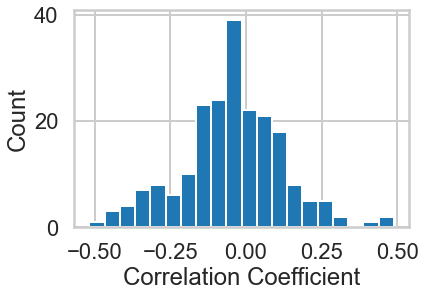

In [70]:
# Look at a histogram of the correlations between age and the 335 CpG sites
df_cpg_335.Correlation.hist(bins=20)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.show()

In [71]:
# Makle a new dataframe with the 335 CpGs sorted by age and orderd by r 
new_cols = ['PATNO', 'Age'] + list(df_cpg_335.CpG)
df_betas_335s = df_betas_335[new_cols]
df_betas_335_sba = df_betas_335s.sort_values('Age').reset_index(drop=True)
df_betas_335_sba = df_betas_335_sba.iloc[1:, :].reset_index(drop=True)
df_betas_335_sba                                                               

,PATNO,Age,cg01820374,cg22736354,cg19722847,cg15804973,cg09809672,cg06493994,cg04474832,cg22809047,cg13547237,cg01459453,cg00168942,cg11299964,cg13931228,cg20240860,cg26614073,cg05675373,cg25148589,cg16744741,cg12941369,cg14175438,cg22197830,cg25564800,cg03891319,cg07388493,cg07158339,cg10865119,cg01511567,cg11314684,cg09418283,cg04836038,cg16168311,cg22613010,cg04528819,cg10523019,cg04084157,cg23517605,cg17324128,cg10940099,cg13129046,cg19724470,cg07285276,cg07730301,cg13302154,cg10266490,cg26845300,cg09118625,cg02364642,cg03330058,...,cg25101936,cg18983672,cg08090772,cg16408394,cg14727952,cg05755779,cg25683012,cg22289837,cg10376763,cg22637507,cg08965235,cg23092072,cg14258236,cg20947775,cg15661409,cg21378206,cg08030082,cg01584473,cg21950518,cg09191327,cg05960024,cg25411725,cg19346193,cg24081819,cg23941599,cg21211748,cg06513075,cg16579101,cg12616277,cg15988232,cg02275294,cg24262469,cg04452713,cg18180783,cg08251036,cg16150435,cg11388238,cg27202708,cg08186124,cg24254120,cg25552492,cg25070637,cg18956095,cg03019000,cg18984151,cg02154074,cg06836772,cg16241714,cg15381769,cg08413469
0,3074,31.160903,0.303123,0.137676,0.145231,0.371432,0.581975,0.181057,0.254395,0.700692,0.304366,0.807582,0.628948,0.311725,0.055165,0.221522,0.504442,0.019968,0.134842,0.400421,0.378897,0.196455,0.675707,0.254970,0.060340,0.461247,0.407096,0.149360,0.186938,0.436725,0.011978,0.085255,0.096370,0.054478,0.106013,0.156592,0.115066,0.158843,0.191994,0.013834,0.195218,0.299440,0.843998,0.286591,0.394859,0.158846,0.035528,0.615090,0.296156,0.306664,...,0.488675,0.897742,0.021305,0.049900,0.026902,0.852191,0.033207,0.400038,0.923776,0.036420,0.207203,0.032921,0.901507,0.033478,0.930477,0.916426,0.528414,0.889742,0.048978,0.028151,0.947347,0.797780,0.901236,0.089364,0.075886,0.030165,0.034445,0.040966,0.052988,0.500640,0.063754,0.313233,0.082350,0.928496,0.915470,0.865495,0.027329,0.426892,0.017229,0.038285,0.086926,0.037031,0.058422,0.817418,0.198454,0.117192,0.147782,0.010180,0.031100,0.026467
1,3011,31.901370,0.348166,0.238470,0.139574,0.520546,0.585116,0.159440,0.259437,0.669858,0.289777,0.872332,0.703799,0.295301,0.089964,0.258355,0.473494,0.028516,0.174512,0.428863,0.419095,0.158818,0.732550,0.237616,0.052964,0.496990,0.439005,0.184459,0.225893,0.407918,0.011076,0.092615,0.129097,0.074021,0.137300,0.175262,0.146662,0.207052,0.185251,0.016123,0.197593,0.314275,0.838415,0.375824,0.437709,0.208267,0.064196,0.558871,0.289757,0.319497,...,0.676400,0.914182,0.018133,0.041161,0.036730,0.888762,0.018600,0.352775,0.755106,0.039252,0.153060,0.018204,0.906873,0.047486,0.883096,0.942031,0.522586,0.853635,0.086001,0.038120,0.938929,0.879801,0.888552,0.083185,0.089728,0.061607,0.035727,0.041518,0.052490,0.457759,0.044132,0.348837,0.096467,0.872624,0.931166,0.840101,0.029361,0.315906,0.016740,0.028768,0.106440,0.035491,0.049751,0.734981,0.181834,0.170213,0.161895,0.011789,0.034745,0.052253
2,3619,32.191781,0.343051,0.194008,0.146119,0.359727,0.567297,0.146799,0.259592,0.675253,0.292288,0.801633,0.614452,0.291350,0.084125,0.277251,0.524533,0.028876,0.125386,0.386691,0.329875,0.187085,0.742800,0.213819,0.068339,0.512811,0.422042,0.113818,0.211226,0.382782,0.011573,0.067956,0.104392,0.054985,0.122347,0.191460,0.129679,0.146981,0.190278,0.011144,0.144856,0.224768,0.900700,0.352539,0.439757,0.202837,0.072180,0.638513,0.283594,0.339924,...,0.635660,0.892022,0.023049,0.043068,0.029985,0.876049,0.020588,0.302481,0.894300,0.031295,0.152469,0.036178,0.910621,0.026872,0.889836,0.919692,0.547940,0.832399,0.040306,0.041168,0.937204,0.903570,0.889803,0.091445,0.084492,0.039144,0.036477,0.040702,0.059753,0.504744,0.092413,0.328022,0.053050,0.912860,0.914634,0.899865,0.033750,0.232351,0.015570,0.030787,0.097468,0.041444,0.067122,0.754705,0.207333,0.111062,0.124878,0.010531,0.034407,0.030240
3,3355,32.331507,0.405405,0.291540,0.182761,0.424370,0.554658,0.205904,0.302023,0.654098,0.338483,0.728752,0.685360,0.324332,0.076214,0.193890,0.558616,0.024571,0.212257,0.463719,0.264575,0.136955,0

In [72]:
## Run PCA on the 335 CpGs
X = df_betas_335_sba.iloc[:, 2:]
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(X)
X_t = pca.transform(X) # create transformed dataset

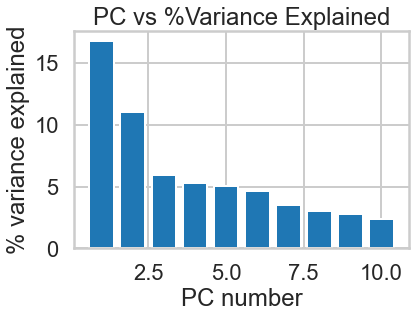

In [73]:
# Plotting % Variance explained by each PC
plt.figure(figsize=(6,4))
plt.bar(range(1,11, 1) , pca.explained_variance_ratio_*100)
plt.xlabel('PC number')
plt.ylabel('% variance explained')
plt.title('PC vs %Variance Explained')
plt.show()

In [74]:
# Make a dataframe of the PCA results
df_X_t = pd.DataFrame(X_t, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_X_t.insert(0, 'Age', df_betas_335_sba.Age)

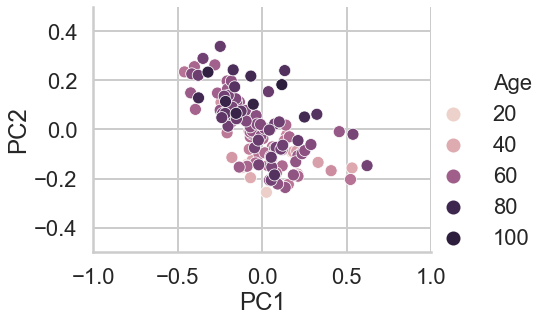

In [75]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='Age', data =df_X_t, height=5, aspect= 1.3 )
plt.ylim(-0.5, 0.5)
plt.xlim(-1, 1)
plt.show()

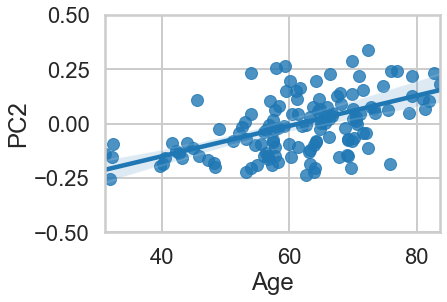

In [76]:
# Make a regression plot with Age and PC2
sns.regplot(x='Age', y='PC2', data=df_X_t)
plt.ylim(-0.5, 0.5)
plt.show()

In [77]:
# Calculate the correlation coefficient between age and PC2
df_X_t.Age.corr(df_X_t.PC2)

0.393353875043635

In [78]:
# Run a linear regression model , all 10 PCs on Age
import statsmodels.api as sm
X = df_X_t.iloc[:, 1:]
X_plus = sm.add_constant(X)
Y_plus = df_X_t.Age
model= sm.OLS(Y_plus, X_plus)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     23.62
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           3.21e-24
Time:                        17:30:05   Log-Likelihood:                -439.07
No. Observations:                 134   AIC:                             900.1
Df Residuals:                     123   BIC:                             932.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.5384      0.578    106.492      0.0

### Now looking at CpGs in common between the Horvath 335 and the PPMI Top1000

In [44]:
# Read in list if Top1000 most correlated CpGs with age pickled from the Top1000 analysis
open_file = open('../files/df_betas_1000_sba_columns', "rb")
df_betas_1000_sba_columns = pickle.load(open_file)
open_file.close()
len(df_betas_1000_sba_columns)

1000

In [45]:
# find CpGs in Common
count=0
common_cpgs = []
for col in df_betas_335_sba.columns:
    if col in df_betas_1000_sba_columns:
        count+=1
        common_cpgs.append(col)
print(count)
common_cpgs

8


['cg01820374',
 'cg22736354',
 'cg19722847',
 'cg15804973',
 'cg09809672',
 'cg06493994',
 'cg04474832',
 'cg22809047']

In [46]:
# Make a dataframe with just those 14 CpGs
df_betas_14_sba = df_betas_335_sba[common_cpgs]
df_betas_14_sba

,cg01820374,cg22736354,cg19722847,cg15804973,cg09809672,cg06493994,cg04474832,cg22809047
0,0.303123,0.137676,0.145231,0.371432,0.581975,0.181057,0.254395,0.700692
1,0.348166,0.238470,0.139574,0.520546,0.585116,0.159440,0.259437,0.669858
2,0.343051,0.194008,0.146119,0.359727,0.567297,0.146799,0.259592,0.675253
3,0.405405,0.291540,0.182761,0.424370,0.554658,0.205904,0.302023,0.654098
4,0.353384,0.226539,0.131751,0.372865,0.562451,0.158598,0.267793,0.593243
...,...,...,...,...,...,...,...,...
129,0.255169,0.297170,0.075725,0.299453,0.445990,0.260637,0.212914,0.644613
130,0.234219,0.297966,0.117955,0.325325,0.323711,0.212429,0.195502,0.654545
131,0.197167,0.282569,0.057521,0.313280,0.349429,0.216883,0.180778,0.725888
132,0.278339,0.261345,0.080312,0.289890,0.316674,0.286700,0.179836,0.719133


In [47]:
## Run PCA on the 14 CpGs
X = df_betas_14_sba.values
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(X)
X_t = pca.transform(X) # create transformed dataset

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=8 with svd_solver='full'

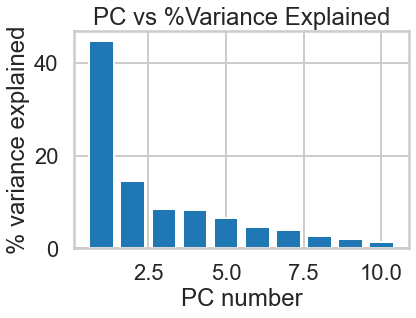

In [40]:
# Plotting % Variance explained by each PC
plt.figure(figsize=(6,4))
plt.bar(range(1,11, 1) , pca.explained_variance_ratio_*100)
plt.xlabel('PC number')
plt.ylabel('% variance explained')
plt.title('PC vs %Variance Explained')
plt.show()

In [41]:
# Make a dataframe of the PCA results from the 14 CpG dataset
df_X_t = pd.DataFrame(X_t, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_X_t.insert(0, 'Age', df_betas_335_sba.Age)

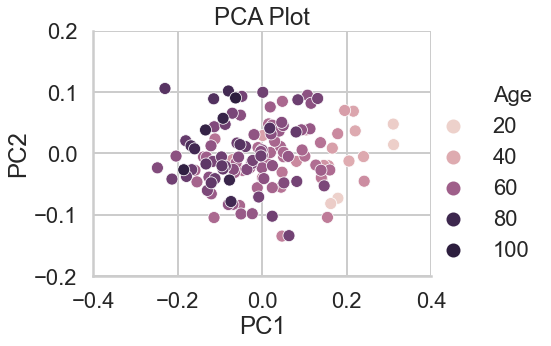

In [42]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='Age', data =df_X_t, height=5, aspect= 1.3 )
plt.ylim(-0.2, 0.2)
plt.xlim(-0.4, 0.4)
plt.title("PCA Plot")
plt.show()

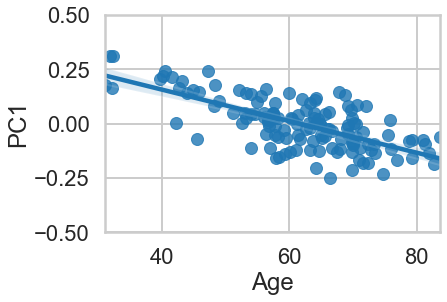

In [43]:
# Make a regression plot with Age and PC1
sns.regplot(x='Age', y='PC1', data=df_X_t)
plt.ylim(-0.5, 0.5)
plt.show()

In [50]:
# Calculate Correlation Coef Age and PC1
df_X_t.Age.corr(df_X_t.PC1)

-0.6891033648423344

In [44]:
# Run a linear regression model , all 10 PCs on Age
import statsmodels.api as sm
X = df_X_t.iloc[:, 1:]
X_plus = sm.add_constant(X)
Y_plus = df_X_t.Age
model= sm.OLS(Y_plus, X_plus)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     34.06
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           7.54e-31
Time:                        10:39:17   Log-Likelihood:                -421.97
No. Observations:                 134   AIC:                             865.9
Df Residuals:                     123   BIC:                             897.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.5384      0.509    120.987      0.0

In [45]:
# Run a linear regression model with 14 CpG data directly
import statsmodels.api as sm
X = df_betas_14_sba.values
X_plus = sm.add_constant(X)
Y_plus = df_X_t.Age
model= sm.OLS(Y_plus, X_plus)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     29.05
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           7.84e-32
Time:                        10:40:38   Log-Likelihood:                -411.34
No. Observations:                 134   AIC:                             852.7
Df Residuals:                     119   BIC:                             896.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.8902     11.068      7.218      0.0